In [37]:
import pickle
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from functions import get_movies_scores, get_infos, get_X
from variable_selection_metrics import user_questions, random_questions, loop_simulation, metrics_simulations, pre_compute_tree
from metrics import random_forest, forward_feature_selection, backward_feature_elimination, random_variable_choice, variable_mean_choice

In [2]:
%load_ext autoreload
%autoreload 2

In [176]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load data

In [3]:
artists = pd.read_csv("data/hetrec2011-lastfm-2k/artists.dat", sep="\t", usecols=['id', 'name', 'url', 'pictureURL'])

In [4]:
with open("data/hetrec2011-lastfm-2k/tags.dat") as f:
    lines = f.readlines()
    ids = []
    values = []
    for i, line in enumerate(lines[1:]):
        ids.append(line.strip().split("\t")[0])
        values.append(line.strip().split("\t")[1])
    tags = pd.DataFrame({'tagID': ids, 'tagValue': values})

In [5]:
user_artists = pd.read_csv("data/hetrec2011-lastfm-2k/user_artists.dat", sep="\t", usecols=['userID', 'artistID', 'weight'])

In [6]:
user_friends = pd.read_csv("data/hetrec2011-lastfm-2k/user_friends.dat", sep="\t", usecols=['userID', 'friendID'])

In [7]:
user_taggedartists = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists.dat", sep="\t", usecols=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])

In [8]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [9]:
user_artists

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [10]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [11]:
tags.tagID = tags.tagID.transform(int)

In [12]:
user_taggedartists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


# Data cleaning

- Plotting tag occurence and removing less represented
- Compute time of algorithms
- Compute correlation matrix of tags
- Remove of the tag with too high correlation
- Compute time again

In [13]:
tags.size

23892

In [14]:
user_taggedartists.tagID.unique().size

9749

### Il y a la moitié des tags qui ne sont même pas utilisés

Regardons la répartition des tags et coupons les moins utiles

In [15]:
usefull_tags = user_taggedartists.tagID.unique().copy()

In [16]:
counts = user_taggedartists.tagID.value_counts()
counts

73      7503
24      5418
79      5251
18      4672
81      4458
        ... 
7620       1
7748       1
5701       1
1607       1
2049       1
Name: tagID, Length: 9749, dtype: int64

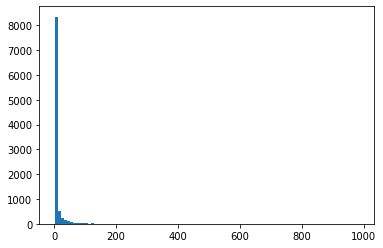

In [17]:
plt.hist(counts[counts < 1000], bins=100)
plt.show()

In [18]:
counts[counts > 10].size

1403

In [19]:
counts[counts > 500].size

73

In [21]:
selected = counts[counts > 100].index

In [22]:
selected_tags = tags[[(i in selected) for i in tags.tagID]]

In [23]:
selected_tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
3,4,black metal
4,5,death metal
5,6,industrial metal


In [24]:
selected_tags.shape

(226, 2)

## Etude de la matrice de corrélation

In [25]:
selected_user_taggedartists = user_taggedartists[[(i in selected) for i in user_taggedartists.tagID]]

In [26]:
selected_user_taggedartists.tagID.unique().size

226

In [145]:
def create_experiment_df(user_artists, tags, user_taggedartists):
    weights = user_artists.weight
    maxw = np.max(weights)
    threshold = np.exp(0.5 * np.log(maxw))
    ratings = np.zeros(weights.size, dtype=int)
    for i in range(len(ratings)):
        ratings[i] = (-5) * np.log(weights.iloc[i] / maxw) / np.log(maxw)
    
    experiment_dict = {
        "item":user_artists.artistID,
        "user":user_artists.userID,
        "rating":ratings,
    }
    
    l = user_artists.artistID.size
    for tag in tags.tagID:
        experiment_dict[int(tag)] = np.zeros(l, dtype=int)
    
    for i in range(user_taggedartists.userID.size):
        experiment_dict[user_taggedartists.tagID.iloc[i]][user_artists.artistID == user_taggedartists.artistID.iloc[i]] += 1
        
    experiment_df = pd.DataFrame(experiment_dict)
    
    return experiment_df

In [146]:
sel_exp_df = create_experiment_df(user_artists, selected_tags, selected_user_taggedartists)

In [147]:
sel_exp_df.head()

,item,user,rating,1,2,4,5,6,7,13,...,1492,1534,1627,1753,1754,1911,1995,2139,2349,2726
0,51,2,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,52,2,1,0,0,0,0,0,0,10,...,1,0,0,0,0,0,0,0,0,0
2,53,2,1,0,0,0,0,0,0,16,...,1,1,0,0,0,1,0,0,1,0
3,54,2,1,0,0,0,0,0,0,8,...,1,0,0,0,0,0,0,0,0,0
4,55,2,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [30]:
correlations = get_X(sel_exp_df).corr()

In [44]:
to_remove = set()
X = get_X(sel_exp_df)
for i in correlations.columns:
    for j in correlations.columns:
        if i > j and correlations.loc[i][j] > 0.8:
            if X.loc[i].sum() > X.loc[j].sum():
                to_remove.add(j)
            else :
                to_remove.add(i)

In [45]:
selected_tags_v2 = selected_tags[[(i not in to_remove) for i in selected_tags.tagID]]

In [46]:
selected_user_taggedartists_v2 = selected_user_taggedartists[[(i not in to_remove) for i in selected_user_taggedartists.tagID]]

In [47]:
selected_user_taggedartists_v2.tagID.unique().size

194

In [36]:
sel_exp_df_v2 = create_experiment_df(user_artists, selected_tags_v2, selected_user_taggedartists_v2)

# Create usable data (skip if data available)

Weight (amount of listening of an artist from an user) convert to a rating (0 or 5) to fit functions

In [ ]:
experiment_df = create_experiment_df(user_artists, tags, user_taggedartists)

In [ ]:
experiment_df.head()

In [39]:
filename = 'experiment_clean_lastfm.pkl'
outfile = open(filename,'wb')
pickle.dump(sel_exp_df,outfile,protocol=4)
outfile.close()

In [95]:
filename = 'experiment_small_lastfm.pkl'
outfile = open(filename,'wb')
pickle.dump(sel_exp_df,outfile,protocol=4)
outfile.close()

In [31]:
filename = 'selected_user_taggedartists.pkl'
outfile = open(filename,'wb')
pickle.dump(selected_user_taggedartists,outfile,protocol=4)
outfile.close()

# Load experiment data (skip if not generated)

In [ ]:
pkl = open('experiment_lastfm.pkl','rb')
experiment_df = pickle.load(pkl)
pkl.close()

# Create preprocess trees

In [149]:
df = sel_exp_df.copy()
for c in get_X(sel_exp_df):
    df[c][df[c] >= 1] = 1

C:\Users\Visiteur\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [150]:
t10rf = pre_compute_tree(df, random_forest, depth = 10)
t10ffs = pre_compute_tree(df, forward_feature_selection, depth = 10)
t10rvc = pre_compute_tree(df, random_variable_choice, depth = 10)
t10vmc = pre_compute_tree(df, variable_mean_choice, depth = 10)

C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

In [151]:
trees = {"RF":t10rf, "FFS":t10ffs, "RVC":t10rvc, "VMC":t10vmc}

In [152]:
t10rf.v

127

In [153]:
t10ffs.v

79

In [154]:
t10rvc.v

242

In [155]:
t10vmc.v

73

In [69]:
tags[tags.tagID == 127]

,tagID,tagValue
126,127,seen live


# Experiments

In [41]:
df.item.unique().size

17632

In [42]:
df.user.unique().size

1892

In [43]:
df.columns.size

229

In [44]:
#user_result = user_questions(df, random_variable_choice)

In [177]:
metric_list = [random_forest, forward_feature_selection, random_variable_choice, variable_mean_choice]
metric_names = ["RF", "FFS", "RVC", "VMC"]

loopsize = 20

In [178]:
results, times, question_counts = metrics_simulations(df, metric_list, metric_names, loopsize, display=True, trees = trees)

 ========== RF ========== 
k = 0
k = 5
k = 10
k = 15
 ========== FFS ========== 


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


k = 0


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

k = 5


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

k = 10


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

k = 15


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

 ========== RVC ========== 
k = 0
k = 5
k = 10
k = 15
 ========== VMC ========== 
k = 0
k = 5
k = 10
k = 15


In [175]:
results2, times2, question_counts2 = metrics_simulations(df, metric_list, metric_names, loopsize, display=True, trees = trees)

In [ ]:
results_array = [results, results2]#, results3, results4]

In [179]:
full_results = {
    'RF':np.zeros(len(results['RF'].keys()), dtype=int),
    'FFS':np.zeros(len(results['RF'].keys()), dtype=int),
    'RVC':np.zeros(len(results['RF'].keys()), dtype=int),
    'VMC':np.zeros(len(results['RF'].keys()), dtype=int),
}

In [180]:
for metric in metric_names:
    for i, k in enumerate(results[metric].keys()):
        full_results[metric][i] += results[metric][k]

In [133]:
times['RF']

50.88235738277435

In [ ]:
times_array = [times, times2]
qc_array = [question_counts, question_counts2]

In [ ]:
for r in results_array:
    for metric in metric_names:
        for i, k in enumerate(results[metric].keys()):
            full_results[metric][i] += r[metric][k]

In [ ]:
full_times = {}
full_qc = {}
for metric in metric_names:
    full_times[metric] = np.mean([t[metric] for t in times_array])
    full_qc[metric] = np.concatenate([q[metric] for q in qc_array])

In [162]:
full_results['VMC'].sum()

79

In [165]:
full_results['FFS'].sum()

0

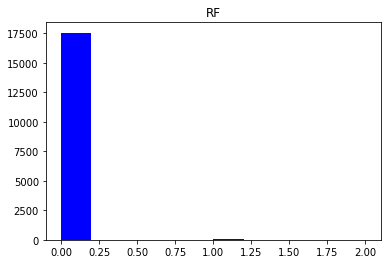

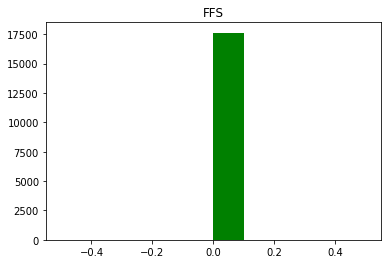

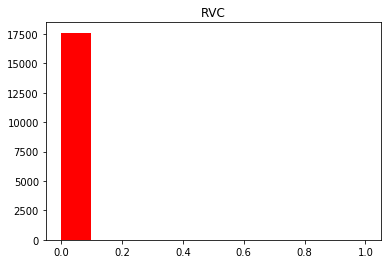

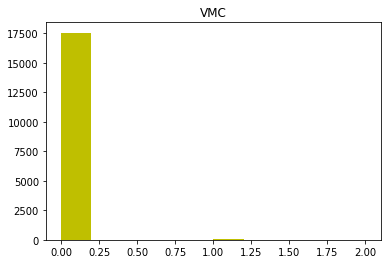

In [181]:
for name, color in zip(metric_names, ['b','g','r','y']):
    plt.hist(full_results[name], color=color)
    plt.title(name)
    plt.show()

Text(0.5, 1.0, 'Time per question sequence')

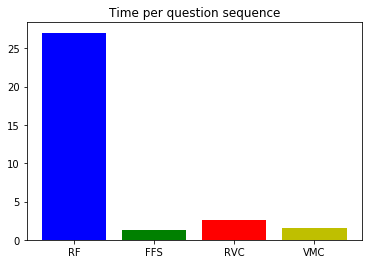

In [182]:
plt.bar(times.keys(), times.values(), color = ['b','g','r','y'])
plt.title('Time per question sequence')

Text(0.5, 1.0, 'Average amount of questions')

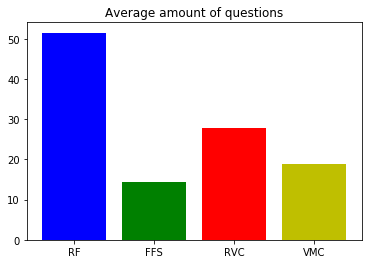

In [183]:
plt.bar(question_counts.keys(), [np.mean(v) for v in question_counts.values()], color = ['b','g','r','y'])
plt.title('Average amount of questions')

Text(0.5, 1.0, 'Minimum amount of questions')

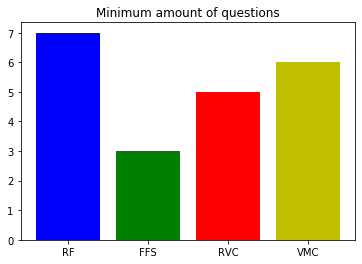

In [184]:
plt.bar(question_counts.keys(), [np.min(v) for v in question_counts.values()], color = ['b','g','r','y'])
plt.title('Minimum amount of questions')

Text(0.5, 1.0, 'Maximum amount of questions')

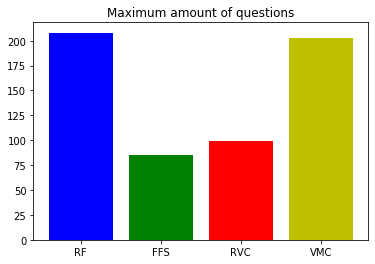

In [185]:
plt.bar(question_counts.keys(), [np.max(v) for v in question_counts.values()], color = ['b','g','r','y'])
plt.title('Maximum amount of questions')

Text(0.5, 1.0, 'Standard deviation of amount of questions')

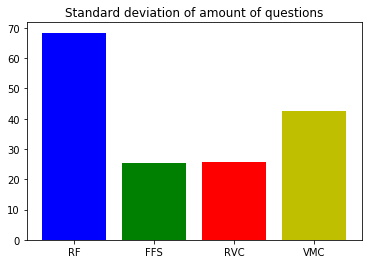

In [186]:
plt.bar(question_counts.keys(), [np.std(v) for v in question_counts.values()], color = ['b','g','r','y'])
plt.title('Standard deviation of amount of questions')

In [96]:
import random as rd

In [97]:
p = 0.04

In [132]:
def simu(p):
    c = np.zeros(4, dtype=int)
    i = 0
    while c.sum() < 4:
        for k in range(4):
            if rd.random() < p and c[k] < 1:
                c[k] = 1
        i += 1
    return i

In [133]:
a = []
for _ in range(10000):
    a.append(simu(p))

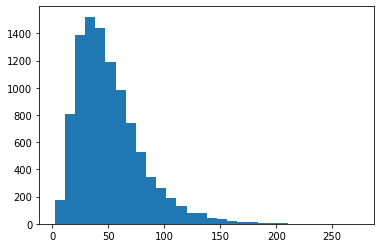

In [134]:
plt.hist(a, bins=30)
plt.show()

In [135]:
np.mean(a)

51.1422

In [136]:
p = 0.0015

In [139]:
def simu(p):
    i = 0
    while True:
        i += 1
        for _ in range(4):
            if rd.random() < p:
                return i

In [206]:
simu(p)

479

In [213]:
a = []
for _ in range(10000):
    a.append(simu(p))

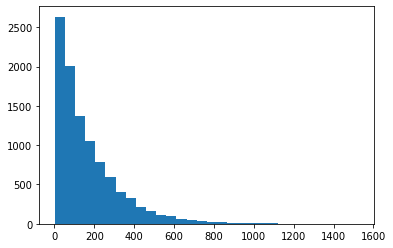

In [214]:
plt.hist(a, bins=30)
plt.show()

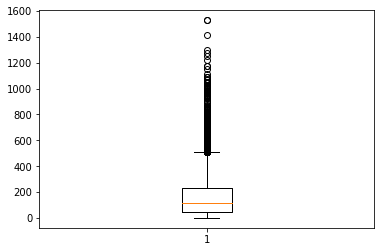

In [220]:
plt.boxplot(a)
plt.show()

In [221]:
a = np.array(a)

In [232]:
np.quantile(a,0.5)

116.0

In [239]:
pow(2,40)

1099511627776